# Exploratory Data Analysis of Stimulus Triggered Averages
*Ian Malone*

### Load data and check structure

In [358]:
import pandas as pd

project = 'NEIL'

path = 'D:\Data\df_STA_%s_2020_12_07.csv' % project
df_sta = pd.read_csv(path)
df_sta.head()

,Animal,Day,Side,Stim_Amplitude,Sample,STA_Amplitude
0,N27,D02,Left,100.0,0,0.035836
1,N27,D02,Left,100.0,1,0.035475
2,N27,D02,Left,100.0,2,0.026637
3,N27,D02,Left,100.0,3,0.021583
4,N27,D02,Left,100.0,4,0.028553


In [359]:
df_sta.dtypes

Animal             object
Day                object
Side               object
Stim_Amplitude    float64
Sample              int64
STA_Amplitude     float64
dtype: object

#### For this analysis, we will only keep the right side EMG for SPARC and left side EMG for Neilsen (for now)

In [360]:
if 'NEIL' in path: 
    df_sta = df_sta[df_sta["Side"] == 'Left']
else:
    df_sta = df_sta[df_sta["Side"] == 'Right']

In [361]:
# this corrects a typo in a file name... 
df_sta.loc[df_sta.Day == 'D13', 'Day'] = 'D14'

In [362]:
print(df_sta.Animal.unique())
print(df_sta.Day.unique())
print(df_sta.Side.unique())
print(df_sta.Stim_Amplitude.unique())

['N27' 'N28' 'N29']
['D02' 'D03' 'D04' 'D05' 'D06']
['Left']
[100. 110. 120. 130. 140. 150. 160. 170. 180. 190. 200. 210. 220. 230.
 240. 250. 260. 270. 280. 290. 300. 310. 320. 330. 340. 350. 360. 370.
 380. 390. 400. 410. 420. 430. 440. 450. 460. 470. 480. 490. 500. 510.
 520. 530. 540. 550. 560. 570. 580. 590. 600.]


#### We will also change the 'Day' column to have integer values.

In [363]:
df_sta['Day'] = df_sta['Day'].str[-2:].astype(int)
df_sta.head(), df_sta.dtypes, 

(  Animal  Day  Side  Stim_Amplitude  Sample  STA_Amplitude
 0    N27    2  Left           100.0       0       0.035836
 1    N27    2  Left           100.0       1       0.035475
 2    N27    2  Left           100.0       2       0.026637
 3    N27    2  Left           100.0       3       0.021583
 4    N27    2  Left           100.0       4       0.028553,
 Animal             object
 Day                 int32
 Side               object
 Stim_Amplitude    float64
 Sample              int64
 STA_Amplitude     float64
 dtype: object)

### Plot stimulus triggered average waveforms
##### For each current amplitude, each animal, and each day
There is a lot of data here, so we will subset. Only plot waveforms of stimulation amplitudes divisible by 50 on odd numbered days. We also need to remove the stimulus artifact.

In [371]:
df_sta_50 = df_sta[(df_sta["Stim_Amplitude"] % 50) == 0] # keep only stimulus amplitudes divisible by 50
"Unique stimulation amplitudes after subsetting are %s uA." % (df_sta_50.Stim_Amplitude.unique())
sampling_frequency = 5000 # hertz
df_sta_50['Time'] = df_sta_50['Sample']/sampling_frequency # create time column based on samples and sampling frequency
df_sta_50['Time'] = df_sta_50['Time']*1000
df_sta_50.head()

<ipython-input-371-a867d2412ee8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sta_50['Time'] = df_sta_50['Sample']/sampling_frequency # create time column based on samples and sampling frequency
<ipython-input-371-a867d2412ee8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sta_50['Time'] = df_sta_50['Time']*1000


,Animal,Day,Side,Stim_Amplitude,Sample,STA_Amplitude,Time
0,N27,2,Left,100.0,0,0.035836,0.0
1,N27,2,Left,100.0,1,0.035475,0.2
2,N27,2,Left,100.0,2,0.026637,0.4
3,N27,2,Left,100.0,3,0.021583,0.6
4,N27,2,Left,100.0,4,0.028553,0.8


###### The plot below is the raw STA data before any processing

<Figure size 1440x864 with 0 Axes>

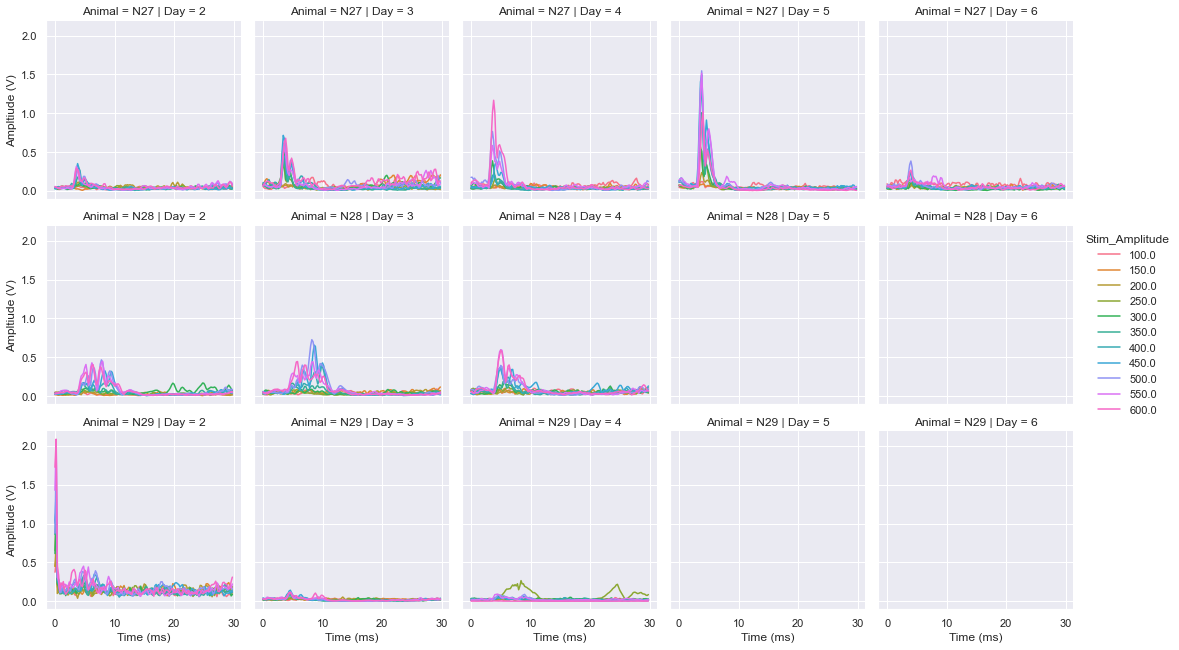

In [373]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1)
plt.figure(figsize=(20,12))

g = sns.FacetGrid(df_sta_50, col='Day', row='Animal', hue='Stim_Amplitude')
g.map_dataframe(sns.lineplot, x='Time', y='STA_Amplitude')
g.set_axis_labels('Time (ms)', 'Ampltiude (V)')
g.add_legend()

###### These traces need to be normalized so they can be compared. This step should be given a lot of thought as normalization schemes can dramatically influence your model. The stimulus artifact must also be removed so it does not affect the normalization.

As a first pass, we will use a min/max scaler. Take all days for each animal and rescale the STAs such that all values are between 0 and 1

In [177]:
# remove the stimulus artifact by deleting samples 0 to 9
df_sta = df_sta[df_sta['Sample'] >= 10]
df_sta_50 = df_sta_50[df_sta_50['Sample'] >= 10]

# scale STA values to be within the range [0,1]
from sklearn.preprocessing import minmax_scale

STA_Scaled = df_sta.groupby(['Animal', 'Side'])['STA_Amplitude'].transform(lambda x: minmax_scale(x.astype(float)))
df_sta_norm = df_sta.copy()
df_sta_norm['STA_Scaled'] = df_sta_norm.index.map(STA_Scaled)
df_sta_norm = df_sta_norm.drop(['STA_Amplitude'], axis=1).reset_index(drop=True)

STA_Scaled_50 = df_sta_50.groupby(['Animal', 'Side'])['STA_Amplitude'].transform(lambda x: minmax_scale(x.astype(float)))
df_sta_50_norm = df_sta_50.copy()
df_sta_50_norm['STA_Scaled'] = df_sta_50_norm.index.map(STA_Scaled_50)
df_sta_50_norm = df_sta_50_norm.drop(['STA_Amplitude'], axis=1).reset_index(drop=True)

###### The plot below shows the normalized STAs with stimulus artifact removed

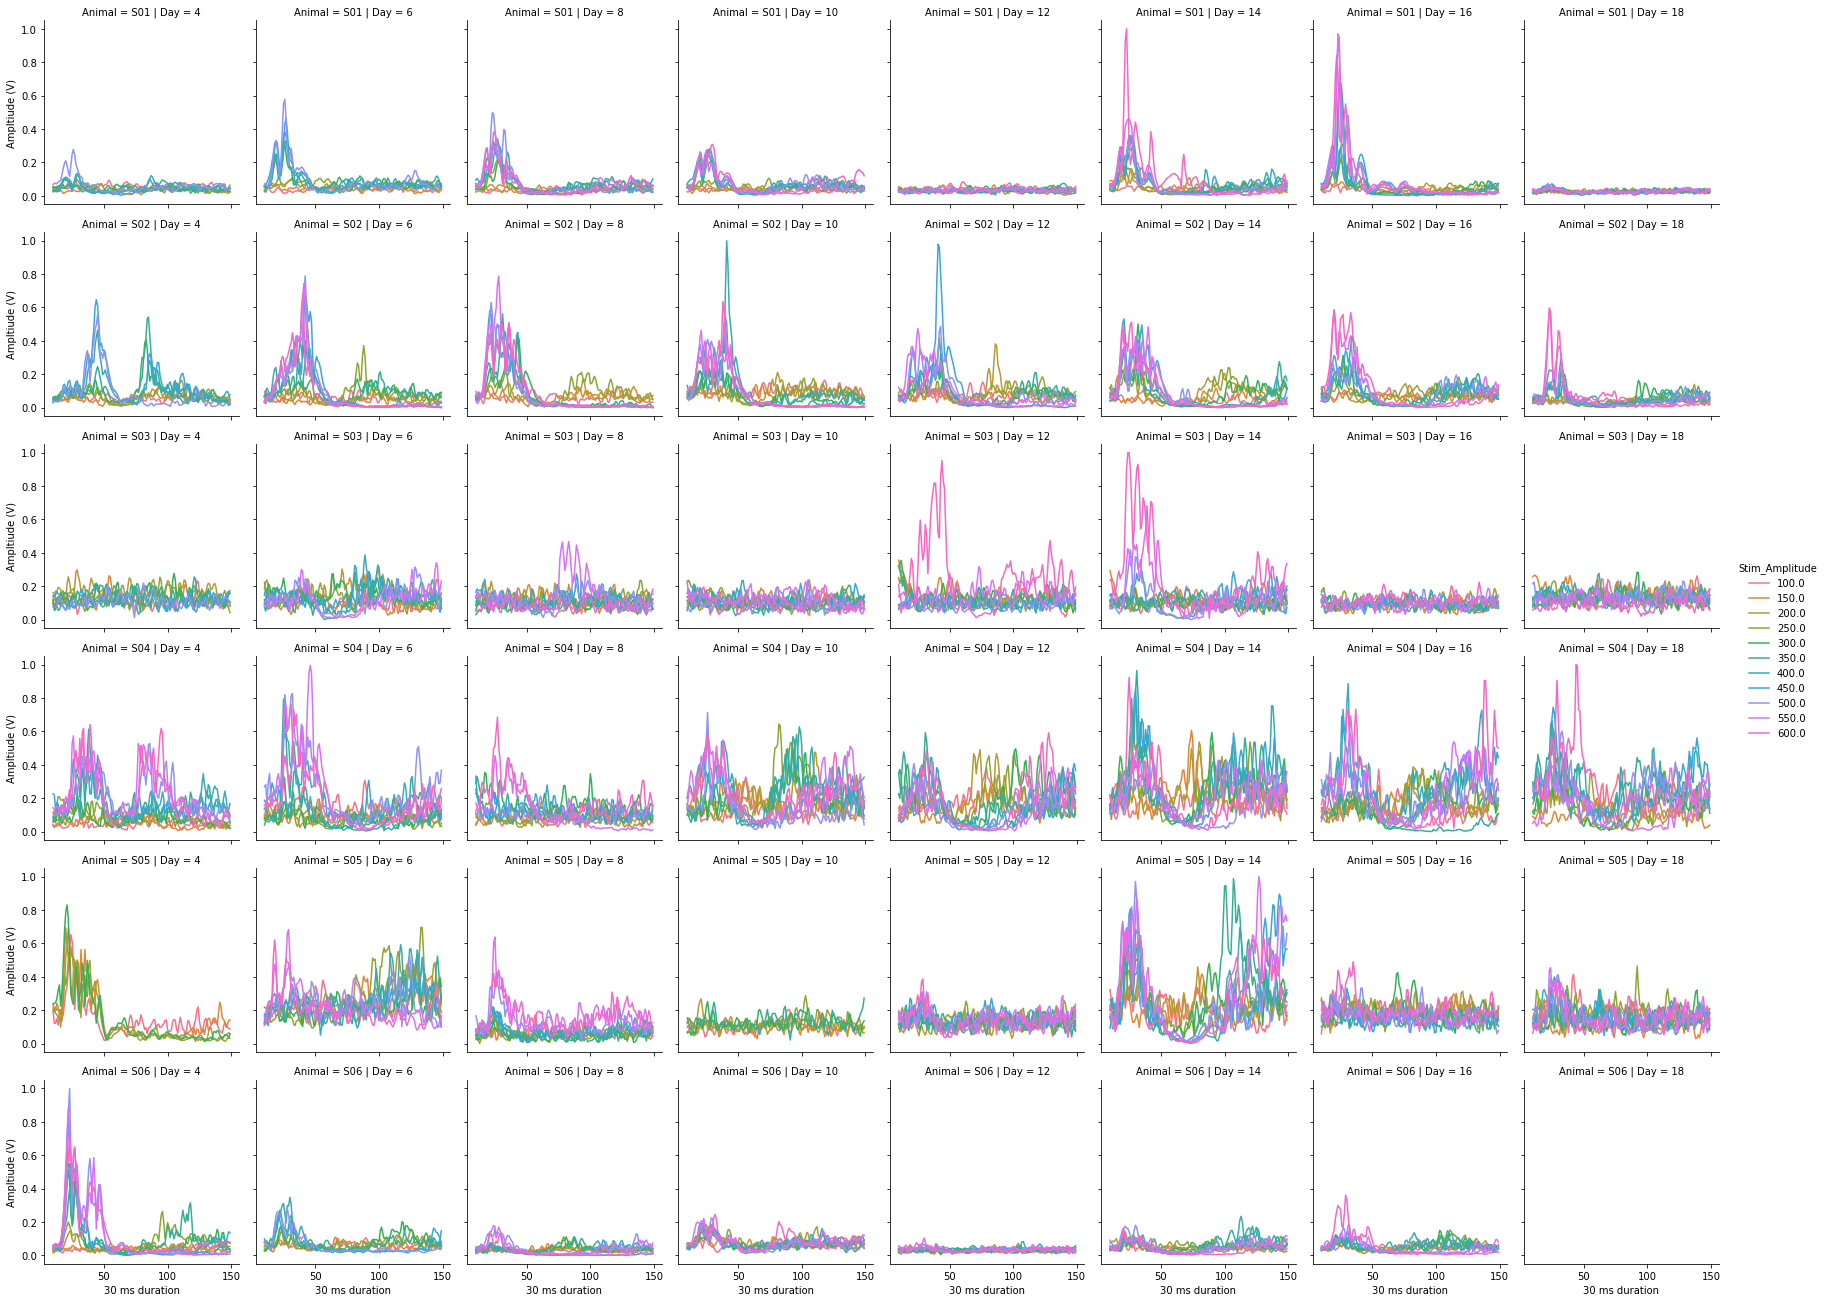

In [178]:
g = sns.FacetGrid(df_sta_50_norm, col='Day', row='Animal', hue='Stim_Amplitude')
g.map_dataframe(sns.lineplot, x='Sample', y='STA_Scaled')
g.set_axis_labels('30 ms duration', 'Ampltiude (V)')
g.add_legend()

### Calculate area under the stimulus triggered average curves 
##### For each current amplitude, each animal, and each day

In [179]:
df_sta_50_norm.head()

,Animal,Day,Side,Stim_Amplitude,Sample,STA_Scaled
0,S01,4,Right,100.0,10,0.049637
1,S01,4,Right,100.0,11,0.035512
2,S01,4,Right,100.0,12,0.036385
3,S01,4,Right,100.0,13,0.048620
4,S01,4,Right,100.0,14,0.056316


The dataframe looks as expected. We now want to add a column that defines sample bins of interest so we can compare metrics at different latencies (e.g., how does the area under the curve differ in the bins 0 to 5 ms vs. 5 to 10 ms?). We will first convert 'Sample' to 'Time' and then define bins of interest.

In [180]:
sampling_frequency = 5000 # hertz
df_sta_50_norm['Time'] = df_sta_50_norm['Sample']/sampling_frequency # create time column based on samples and sampling frequency

In [181]:
bins = [0.001, 0.004, 0.007, 0.010, 0.013, 0.0298] # define bins
labels = ['1 to 4 ms', '4 to 7 ms', '7 to 10 ms', '10 to 13 ms', '13 to 29.8 ms'] # define bin labels
#labels = [1, 2, 3, 4, 5]

df_bin = df_sta_50_norm.copy()
df_bin['Time_Bin'] = pd.cut(df_bin['Time'], bins, labels=labels, right=False) # add Time_Bin column to dataframe
df_bin = df_bin.reindex(columns=['Animal', 'Day', 'Side', 'Stim_Amplitude', 'Sample', 'Time', 'Time_Bin', 'STA_Scaled'])
df_bin.rename(columns = {'Time_Bin':'Bin'}, inplace = True) 
df_bin = df_bin[df_bin['Bin'] != '13 to 29.8 ms'] # drop all data 13 ms after the stimulation
df_bin.head()

,Animal,Day,Side,Stim_Amplitude,Sample,Time,Bin,STA_Scaled
0,S01,4,Right,100.0,10,0.0020,1 to 4 ms,0.049637
1,S01,4,Right,100.0,11,0.0022,1 to 4 ms,0.035512
2,S01,4,Right,100.0,12,0.0024,1 to 4 ms,0.036385
3,S01,4,Right,100.0,13,0.0026,1 to 4 ms,0.048620
4,S01,4,Right,100.0,14,0.0028,1 to 4 ms,0.056316


# Erica df

In [344]:
sampling_frequency = 5000 # hertz
df_sta['Time'] = df_sta['Sample']/sampling_frequency # create time column based on samples and sampling frequency

df_erica = df_sta.copy()
df_erica = df_erica.reindex(columns=['Animal', 'Day', 'Side', 'Stim_Amplitude', 'Sample', 'Time', 'STA_Amplitude'])
df_erica_a = df_erica.groupby(['Animal', 'Day', 'Side', 'Stim_Amplitude'])['STA_Amplitude'].apply(integrate.simps).reset_index()
df_erica_a.rename(columns = {'STA_Amplitude':'STA_AUC'}, inplace = True)
#df_erica_a['STA_Max'] = df_erica.groupby(['Animal', 'Day', 'Side', 'Stim_Amplitude', 'Bin'])['STA_Amplitude'].agg(max).reset_index()['STA_Amplitude']
df_erica_a = df_erica_a.drop(columns=['Side'])
df_erica_a = df_erica_a.dropna()

import numpy as np

# add animal group information to the dataframe
conditions = [
    (df_erica_a['Animal'] == 'S01') | (df_erica_a['Animal'] == 'S02'),
    (df_erica_a['Animal'] == 'S03') | (df_erica_a['Animal'] == 'S04'),
    (df_erica_a['Animal'] == 'S05') | (df_erica_a['Animal'] == 'S06')]
choices = ['Group A', 'Group B', 'Group C']
df_erica_a['Group'] = np.select(conditions, choices)

#df_erica_a = df_erica_a[['Animal','Group','Day','Side','Bin','Stim_Amplitude', 'STA_Max','STA_AUC']]

#df_erica_a.to_csv(r'D:\\Data\\df_erica.csv', index=False) 
df_erica_a.head()

,Animal,Day,Stim_Amplitude,STA_AUC,Group
0,S01,4,100.0,13.377798,Group A
1,S01,4,110.0,10.783805,Group A
2,S01,4,120.0,14.252519,Group A
3,S01,4,130.0,9.771110,Group A
4,S01,4,140.0,10.869471,Group A


In [345]:
df_erica_pchange = df_erica_a.pivot_table(index=['Animal', 'Stim_Amplitude', 'Group'], 
                    columns='Day', 
                    values='STA_AUC').reset_index()



df_erica_pchange.head()

Day,Animal,Stim_Amplitude,Group,4,6,8,10,12,14,16,18
0,S01,100.0,Group A,13.377798,9.814942,9.548306,10.379224,10.862288,9.501607,8.074392,7.238020
1,S01,110.0,Group A,10.783805,9.308021,9.999380,9.949426,11.453339,10.367339,7.568642,6.868103
2,S01,120.0,Group A,14.252519,6.730882,9.847110,9.574024,10.515624,10.783002,6.297457,6.315509
3,S01,130.0,Group A,9.771110,7.705432,9.943525,10.127056,9.503668,11.494268,9.711802,7.259656
4,S01,140.0,Group A,10.869471,11.383752,9.894556,10.691479,10.987215,10.841349,12.119167,6.368231


In [346]:
#df_erica_pchange[16].head()
# function to calculate percent change
# def perc_change_from_d4(df, day):
#     return ((df[str(day)].sub(df['4'])).div(df['4'])).mul(100)


df_erica_pchange["Percent Change AUC Day 4 to Day 16"] = ((df_erica_pchange[16].sub(df_erica_pchange[4])).div(df_erica_pchange[4])).mul(100)
#print(df_erica_pchange['Day'])

# for n in np.arange(6,20,2):
#     df_auc_pchange["Day 4 to Day %s" % n] = perc_change_from_d4(n)

# df_auc_pchange = df_auc_pchange.drop(df_auc_pchange.columns[5:13], axis=1)
df_erica_pchange.head()

Day,Animal,Stim_Amplitude,Group,4,6,8,10,12,14,16,18,Percent Change AUC Day 4 to Day 16
0,S01,100.0,Group A,13.377798,9.814942,9.548306,10.379224,10.862288,9.501607,8.074392,7.238020,-39.643338
1,S01,110.0,Group A,10.783805,9.308021,9.999380,9.949426,11.453339,10.367339,7.568642,6.868103,-29.814735
2,S01,120.0,Group A,14.252519,6.730882,9.847110,9.574024,10.515624,10.783002,6.297457,6.315509,-55.815130
3,S01,130.0,Group A,9.771110,7.705432,9.943525,10.127056,9.503668,11.494268,9.711802,7.259656,-0.606973
4,S01,140.0,Group A,10.869471,11.383752,9.894556,10.691479,10.987215,10.841349,12.119167,6.368231,11.497302


In [347]:
df_erica_plot = df_erica_pchange.groupby(['Group', 'Stim_Amplitude'])['Percent Change AUC Day 4 to Day 16'].agg('mean').reset_index()
df_erica_plot.rename(columns = {'Stim_Amplitude':'Stimulation Amplitude'}, inplace = True) 
df_erica_plot.head()

,Group,Stimulation Amplitude,Percent Change AUC Day 4 to Day 16
0,Group A,100.0,-1.644497
1,Group A,110.0,-13.458884
2,Group A,120.0,-6.665308
3,Group A,130.0,37.085772
4,Group A,140.0,9.519167


<AxesSubplot:xlabel='Stimulation Amplitude', ylabel='Percent Change AUC Day 4 to Day 16'>

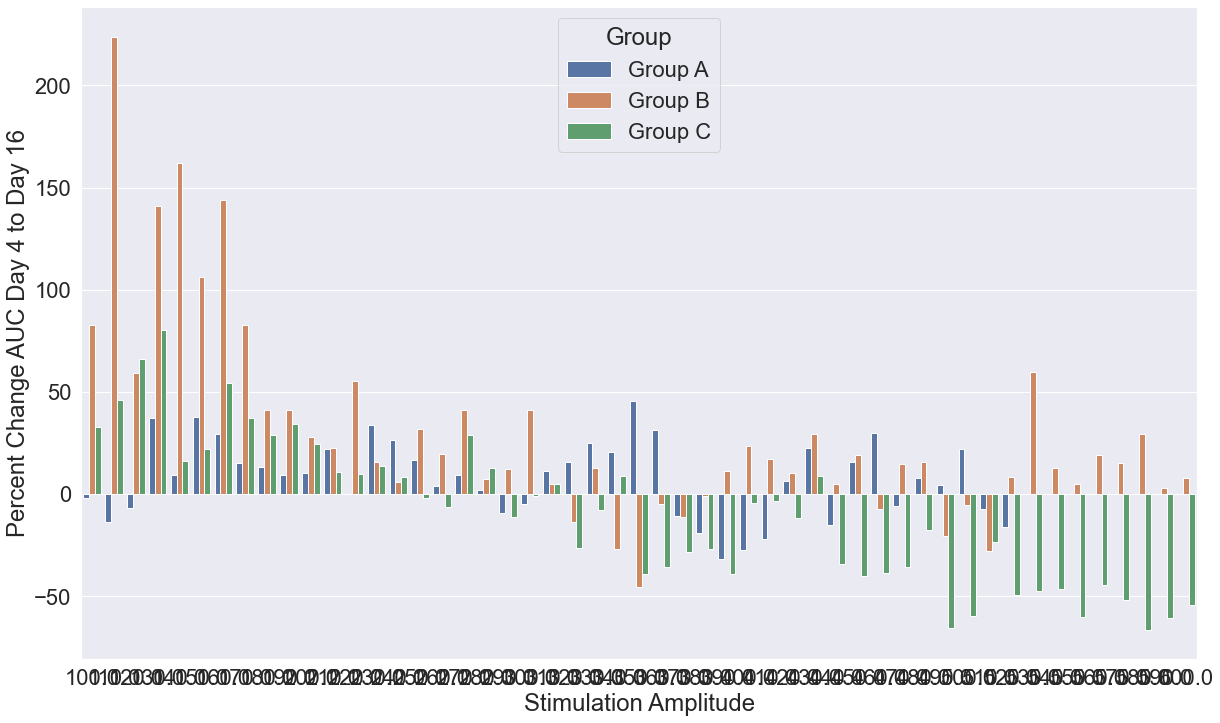

In [350]:
plt.figure(figsize=(20,12))
sns.set(font_scale=2)
sns.barplot(x='Stimulation Amplitude', y='Percent Change AUC Day 4 to Day 16', hue='Group', data=df_erica_plot)



# plt.figure(figsize=(20,12))
# sns.set(font_scale=2)
# sns.set_style("ticks")
# ax = sns.boxplot(x='Group', y='Percent_Change', hue='Stim_Amplitude', data=df_auc_pchange[df_auc_pchange['Days'] == day_range])
# ax.legend(loc="upper left", title='Stimulation Amplitude (uA)', title_fontsize="small")
# ax.set_title(project + ': Percent Change AUC ' + day_range)
# ax.set_ylabel('Percent Change STA AUC')

###### Below is a plot showing the data we will be working with. Data are normalized and are cut off at 13 ms after the stimulus. Also, only stimulation amplitudes divisible by 50 are in this dataframe.

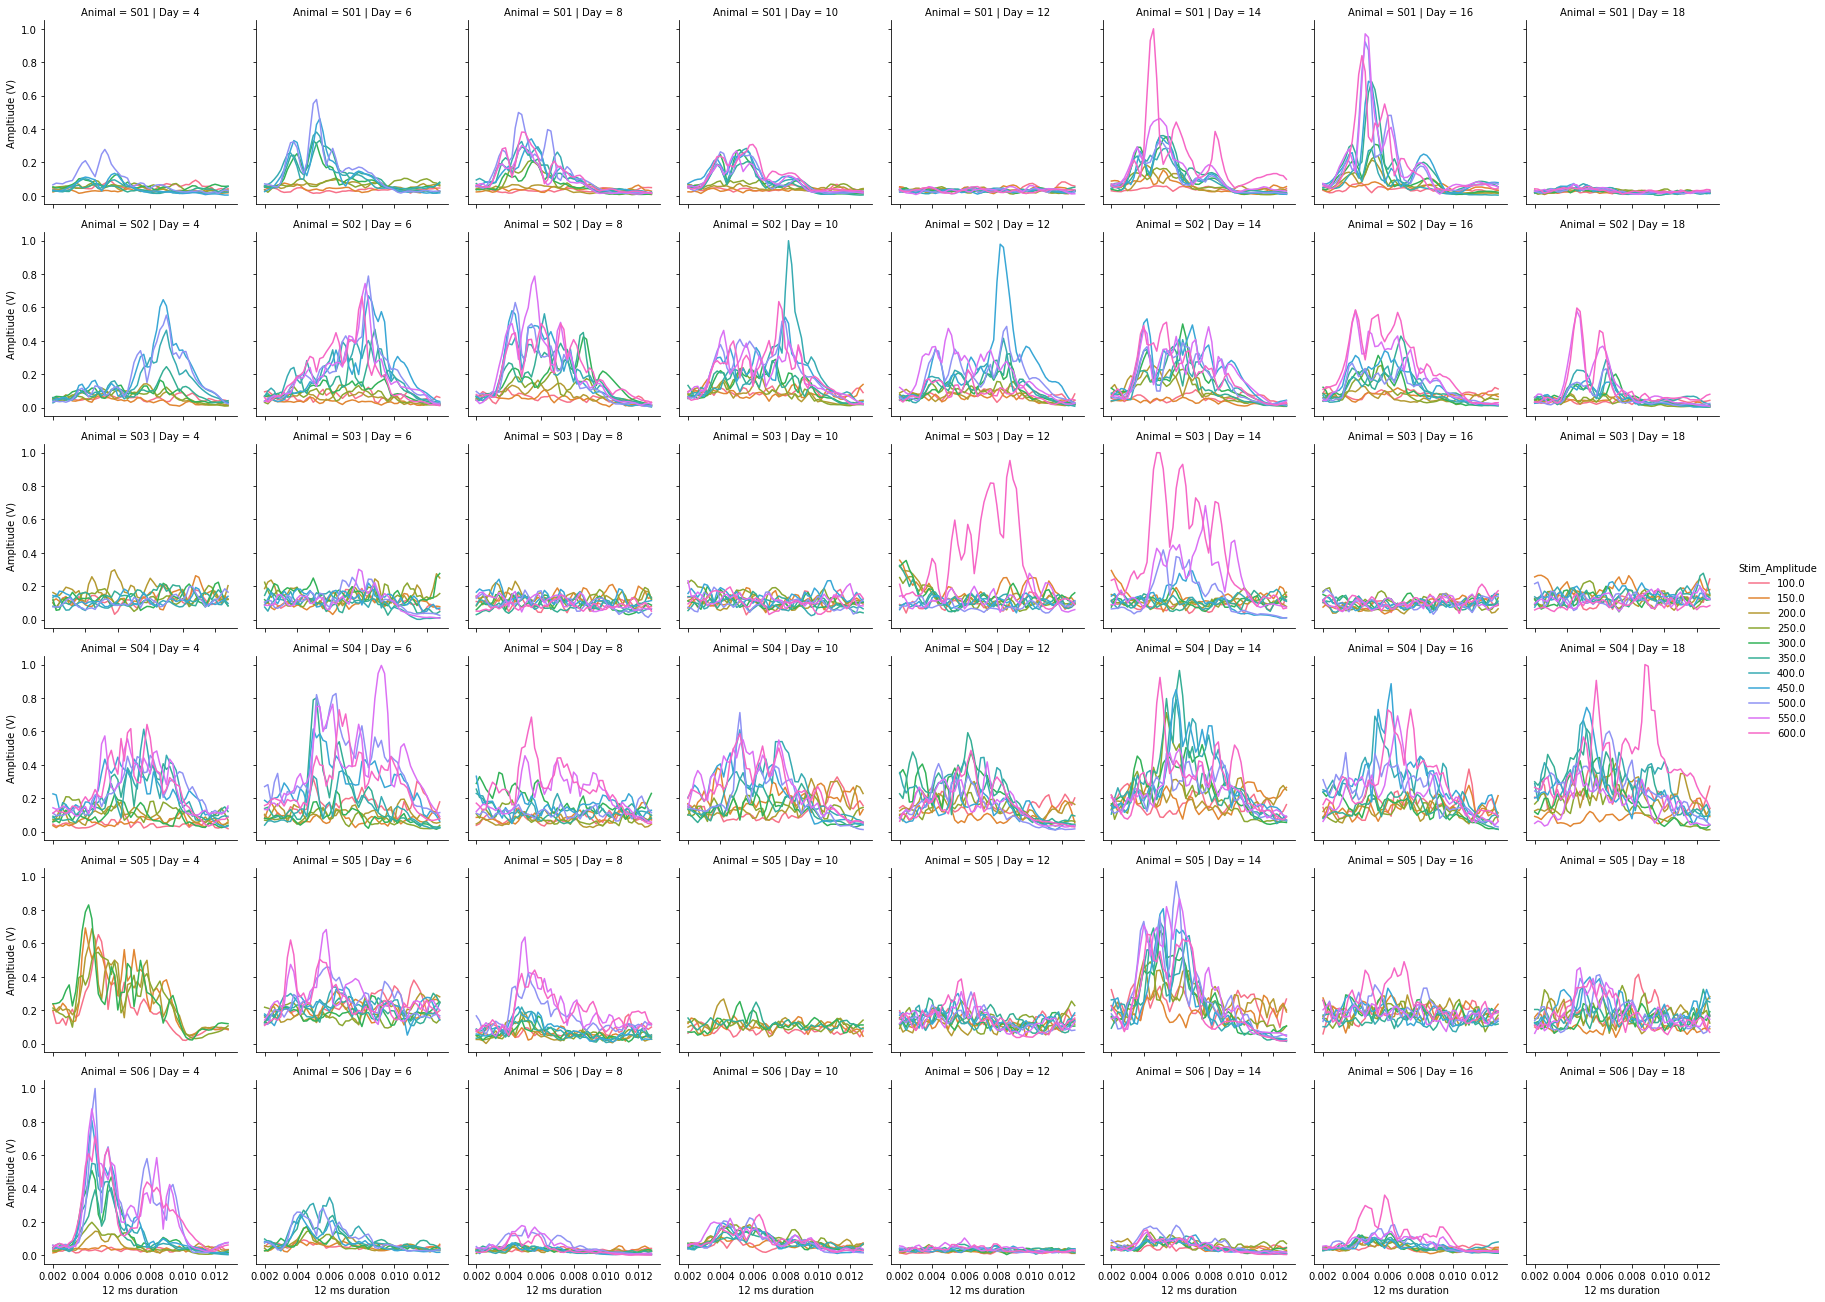

In [14]:
g = sns.FacetGrid(df_bin, col='Day', row='Animal', hue='Stim_Amplitude')
g.map_dataframe(sns.lineplot, x='Time', y='STA_Scaled')
g.set_axis_labels('12 ms duration', 'Ampltiude (V)')
g.add_legend()

We now need to integrate the stimulus triggered average curves to find the area beneath them. We can then compare these areas under the curve (AUCs) between groups, days, stimulus intensities, etc.

The trapezoidal rule provides a simple way to integrate a function but typically has much larger error than Simpson's rule without saving significant compute time. We will use Simpson's rule.

In [182]:
from scipy import integrate

df_auc = df_bin.groupby(['Animal', 'Day', 'Side', 'Stim_Amplitude', 'Bin'])['STA_Scaled'].apply(integrate.simps).reset_index()
df_auc.rename(columns = {'STA_Scaled':'STA_AUC'}, inplace = True)
df_auc = df_auc.dropna()
df_auc.head()

,Animal,Day,Side,Stim_Amplitude,Bin,STA_AUC
0,S01,4,Right,100.0,1 to 4 ms,0.419022
1,S01,4,Right,100.0,4 to 7 ms,0.832242
2,S01,4,Right,100.0,7 to 10 ms,0.780677
3,S01,4,Right,100.0,10 to 13 ms,0.807257
5,S01,4,Right,150.0,1 to 4 ms,0.280608


### Rough work below

In [184]:
import numpy as np

# add animal group information to the dataframe
conditions = [
    (df_auc['Animal'] == 'S01') | (df_auc['Animal'] == 'S02'),
    (df_auc['Animal'] == 'S03') | (df_auc['Animal'] == 'S04'),
    (df_auc['Animal'] == 'S05') | (df_auc['Animal'] == 'S06')]
choices = ['Group A', 'Group B', 'Group C']
df_auc['Group'] = np.select(conditions, choices)
df_auc.head()

,Animal,Day,Side,Stim_Amplitude,Bin,STA_AUC,Group
0,S01,4,Right,100.0,1 to 4 ms,0.419022,Group A
1,S01,4,Right,100.0,4 to 7 ms,0.832242,Group A
2,S01,4,Right,100.0,7 to 10 ms,0.780677,Group A
3,S01,4,Right,100.0,10 to 13 ms,0.807257,Group A
5,S01,4,Right,150.0,1 to 4 ms,0.280608,Group A


In [298]:
# function to calculate percent change
def perc_change_from_d4(df, day):
    return ((df[str(day)].sub(df['4'])).div(df['4'])).mul(100)

In [203]:
### changed function above to take df arg

df_auc_pchange = df_auc.pivot_table(index=['Animal', 'Side', 'Stim_Amplitude', 'Bin', 'Group'], 
                    columns='Day', 
                    values='STA_AUC').reset_index()

for n in np.arange(6,20,2):
    df_auc_pchange["Day 4 to Day %s" % n] = perc_change_from_d4(n)

df_auc_pchange = df_auc_pchange.drop(df_auc_pchange.columns[5:13], axis=1)
df_auc_pchange.head()

Day,Animal,Side,Stim_Amplitude,Bin,Group,Day 4 to Day 6,Day 4 to Day 8,Day 4 to Day 10,Day 4 to Day 12,Day 4 to Day 14,Day 4 to Day 16,Day 4 to Day 18
0,S01,Right,100.0,1 to 4 ms,Group A,-27.492595,-23.789535,-3.985187,-32.249709,-34.897991,-34.450146,-54.934389
1,S01,Right,100.0,4 to 7 ms,Group A,-55.335661,-53.457297,-40.075066,-34.298249,-16.685615,-19.420758,-60.140322
2,S01,Right,100.0,7 to 10 ms,Group A,-37.073048,-38.489385,-23.351924,-35.834801,-28.431806,-44.579683,-53.460703
3,S01,Right,100.0,10 to 13 ms,Group A,-37.266530,-39.663738,-27.217070,0.151266,-38.419893,-51.832248,-56.675109
4,S01,Right,150.0,1 to 4 ms,Group A,102.909225,-4.090707,-5.039629,29.685401,158.800671,65.079660,-41.981925


In [208]:
df_auc_pchange = pd.melt(df_auc_pchange, id_vars=['Animal', 'Side', 'Stim_Amplitude', 'Bin', 'Group'], var_name='Days', value_name='Percent_Change')
df_auc_pchange.head()

,Animal,Side,Stim_Amplitude,Bin,Group,Days,Percent_Change
0,S01,Right,100.0,1 to 4 ms,Group A,Day 4 to Day 6,-27.492595
1,S01,Right,100.0,4 to 7 ms,Group A,Day 4 to Day 6,-55.335661
2,S01,Right,100.0,7 to 10 ms,Group A,Day 4 to Day 6,-37.073048
3,S01,Right,100.0,10 to 13 ms,Group A,Day 4 to Day 6,-37.266530
4,S01,Right,150.0,1 to 4 ms,Group A,Day 4 to Day 6,102.909225


In [271]:
df_auc_pchange[(df_auc_pchange['Group'] == 'Group C') & (df_auc_pchange['Days'] == 'Day 4 to Day 16') & (df_auc_pchange['Animal'] == 'S05')].head(50)

,Animal,Side,Stim_Amplitude,Bin,Group,Days,Percent_Change
1496,S05,Right,100.0,1 to 4 ms,Group C,Day 4 to Day 16,18.455456
1497,S05,Right,100.0,4 to 7 ms,Group C,Day 4 to Day 16,-56.779948
1498,S05,Right,100.0,7 to 10 ms,Group C,Day 4 to Day 16,24.986994
1499,S05,Right,100.0,10 to 13 ms,Group C,Day 4 to Day 16,173.498386
1500,S05,Right,150.0,1 to 4 ms,Group C,Day 4 to Day 16,-18.284108
1501,S05,Right,150.0,4 to 7 ms,Group C,Day 4 to Day 16,-51.692749
1502,S05,Right,150.0,7 to 10 ms,Group C,Day 4 to Day 16,-41.891742
1503,S05,Right,150.0,10 to 13 ms,Group C,Day 4 to Day 16,141.762349
1504,S05,Right,200.0,1 to 4 ms,Group C,Day 4 to Day 16,-15.642828
1505,S05,Right,200.0,4 to 7 ms,Group C,Day 4 to Day 16,-50.780332


C:\Users\Ian\anaconda3\lib\site-packages\seaborn\axisgrid.py:645: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\Ian\anaconda3\lib\site-packages\seaborn\axisgrid.py:650: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


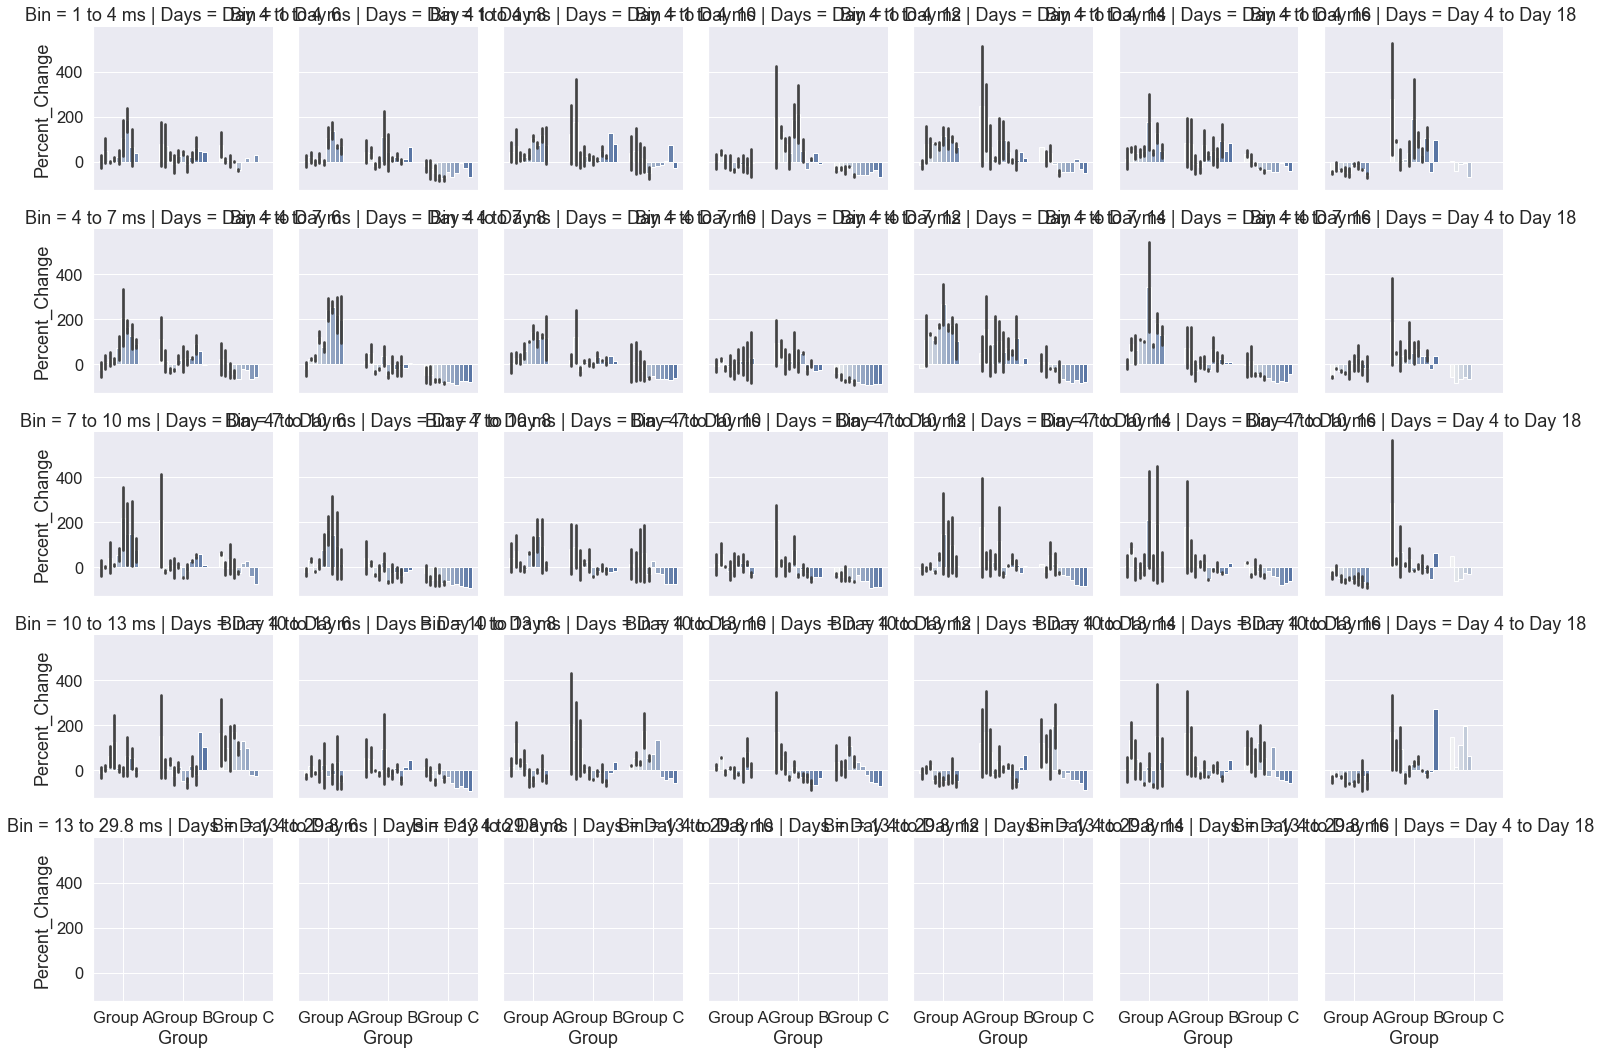

In [261]:
# all the bar plots
sns.set(font_scale=1.5)
g = sns.FacetGrid(df_auc_pchange, col="Days", row='Bin')
g.map(sns.barplot, "Group", "Percent_Change", 'Stim_Amplitude')

Text(0, 0.5, 'Percent Change STA AUC')

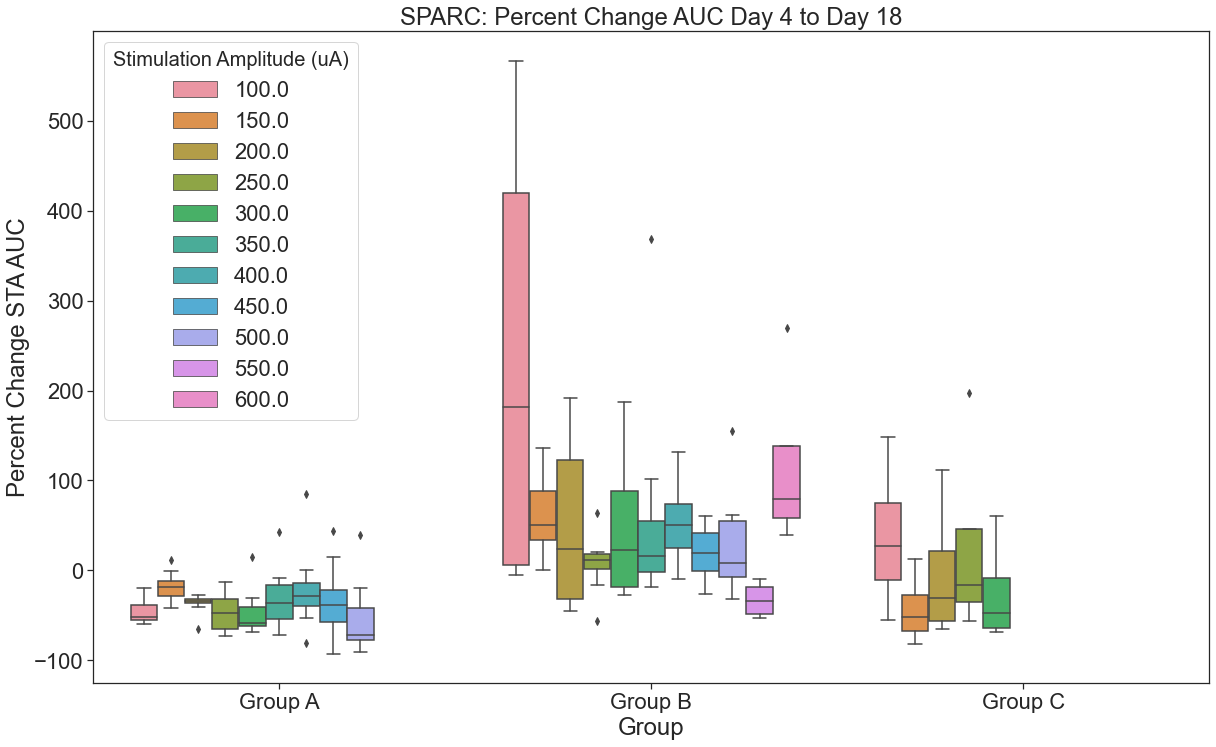

In [258]:
day_range = 'Day 4 to Day 18'

plt.figure(figsize=(20,12))
sns.set(font_scale=2)
sns.set_style("ticks")
ax = sns.boxplot(x='Group', y='Percent_Change', hue='Stim_Amplitude', data=df_auc_pchange[df_auc_pchange['Days'] == day_range])
ax.legend(loc="upper left", title='Stimulation Amplitude (uA)', title_fontsize="small")
ax.set_title(project + ': Percent Change AUC ' + day_range)
ax.set_ylabel('Percent Change STA AUC')

### Other analyses

- Peak to peak from stimulus triggered average for each current amplitude, each animal, each day
- Latency from stimulus pulse to stimulus triggered average for each current amplitude, each animal, each day
- Time domains of stimulus triggered average
- Differences in any of these parameters based on time of day?
- How are we going to present the impedance data in the Neilsen paper? I’m still not clear on this.
- Additional things we can look at (e.g., wavelet, FFT, HMM, etc.)
- Look in manuscript file for notes on ideas. Also look in Daily Notes on OneNote for papers that did EMG analysis well.
- Add information on time of day and stimulus amplitude from Neurochip